# Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Load Data

In [2]:
# load train.csv
train_df = pd.read_csv("./data/train.csv")
train_df

,date,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,...,var,atr,natr,trange,ad,adosc,obv,1_trend,5_trend,10_trend
0,1,94.86,101.36,103.36,94.36,21789208,16.827667,307.142904,-3.555735,-3.246850,...,10.243520,7.920250,8.349410,9.0,-3.848627e+07,-1.167386e+07,261516573.0,1.0,1.0,1.0
1,2,97.59,96.09,99.09,93.09,13642091,15.896730,-22.568827,-2.639682,1.304832,...,7.281680,7.821542,8.014696,6.0,-4.412492e+07,-1.520909e+07,258865213.0,0.0,1.0,1.0
2,3,97.59,94.09,101.59,92.09,16305307,15.562605,-7.225711,-3.147920,-1.168940,...,6.959584,7.941432,8.137547,9.5,-4.155040e+07,-1.235346e+07,258865213.0,1.0,1.0,1.0
3,4,98.69,100.19,102.69,98.69,14127338,15.367623,6.165014,-3.464886,-0.187496,...,3.781264,7.738472,7.841192,5.1,-5.567774e+07,-1.455727e+07,272992551.0,-1.0,0.0,1.0
4,5,96.50,102.00,103.50,95.50,10304396,15.549624,16.710140,-3.691806,-1.918849,...,3.172496,7.757153,8.038501,8.0,-6.340604e+07,-1.659444e+07,262688155.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,1858,131.64,131.64,133.14,131.64,1915360,21.933646,254.843013,1.760688,-0.225027,...,4.348616,2.505854,1.903565,1.5,-1.378997e+09,-1.715582e+06,853638722.0,1.0,-1.0,-1.0
1858,1859,133.34,132.34,134.84,132.34,2765566,20.412209,305.502984,-0.752763,-6.230444,...,0.751400,2.571374,1.928434,2.5,-1.378417e+09,-1.447268e+06,859048286.0,0.0,-1.0,-1.0
1859,1860,134.19,133.19,134.69,132.69,1102925,20.218289,-37.385040,-3.042672,-4.300574,...,0.751400,2.530561,1.885805,2.0,-1.377866e+09,-1.119953e+06,860151211.0,0.0,-1.0,-1.0
1860,1861,133.77,134.27,136.27,133.27,1224191,20.742574,-29.806261,-3.829639,-1.516603,...,0.839464,2.564093,1.916792,3.0,-1.378682e+09,-1.143915e+06,858927020.0,0.0,-1.0,-1.0


# Preprocess

In [3]:
# Create feature. Per 30 days data as an example.
def create_lagged_features(df, days=30):
    features = []
    targets = []
    
    for i in range(days-1, len(df)):
        feature_row = []
        target_1d = df.iloc[i]['1_trend']
#         target_5d = df.iloc[i]['5_trend']
#         target_10d = df.iloc[i]['10_trend']

        # Concat features from day 1 to day 30.
        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume']
            ])
        features.append(feature_row)
        targets.append([target_1d])
    
    return np.array(features), np.array(targets)

# Create feature
features, targets = create_lagged_features(train_df, days=30)

In [4]:
print(features.shape)
print(targets.shape)

(1833, 150)
(1833, 1)


# Training

In [5]:
# Use for Standardization
scaler = StandardScaler()

# Split train set and validation set
X_train, y_train = features[:round(len(features) * 0.8)], targets[:round(len(targets) * 0.8)]
X_val, y_val = features[round(len(features) * 0.8):], targets[round(len(targets) * 0.8):] 

# Standardization
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Use SVM as Classifier, you can try to change kernel
model = SVC(kernel='linear', probability=True, random_state=42)

# Train model
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_val)

# Generate Classification Result
print(f"Report for 1_trend:")
print(classification_report(y_val[:], y_pred[:], zero_division=True))
print('---------------------------------------------------')

c:\Users\jimmy\anaconda3\envs\stock\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Report for 1_trend:
              precision    recall  f1-score   support

        -1.0       0.25      0.04      0.07        99
         0.0       0.50      0.65      0.56       182
         1.0       0.23      0.31      0.27        86

    accuracy                           0.41       367
   macro avg       0.33      0.33      0.30       367
weighted avg       0.37      0.41      0.36       367

---------------------------------------------------


In [6]:
# Validate for overfitting
output_train = model.predict(X_train)
output_val = model.predict(X_val)

train_f1 = f1_score(y_train.flatten(),output_train.flatten(), average='macro')
val_f1 = f1_score(y_val.flatten(), output_val.flatten(), average='macro')

print(f"Training F1: {train_f1}")
print(f"Valid F1: {val_f1}")

Training F1: 0.4733916803350942
Valid F1: 0.3009384117482072


# Chart drawing

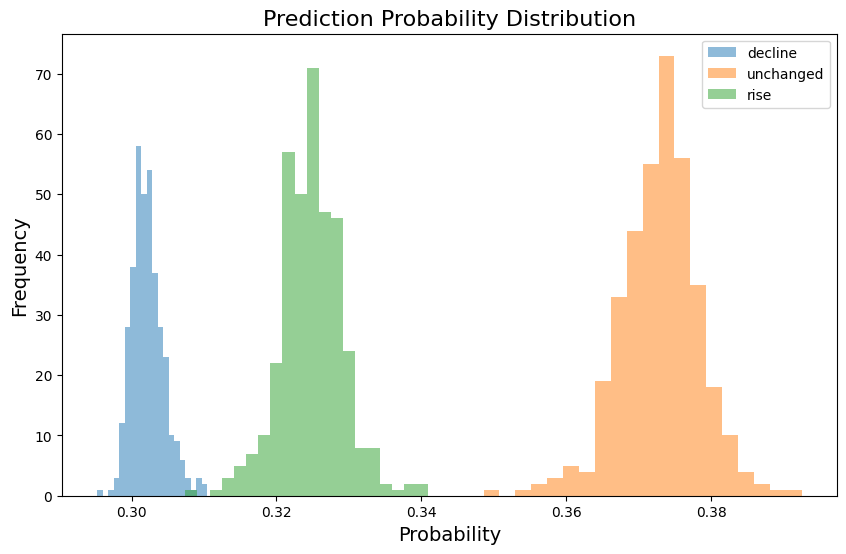

In [7]:
# print the order of output classes
class_map ={-1:"decline", 0:"unchanged", 1:"rise"}
class_order = [class_map[model.classes_[0]], class_map[model.classes_[1]], class_map[model.classes_[2]]]

# The code here draws 1 label(1_trend) chart
prob_1_trend = model.predict_proba(X_val)

# Draw Prediction Probability Distribution 
plt.figure(figsize=(10, 6))

for i in range(prob_1_trend.shape[1]):
    plt.hist(prob_1_trend[:, i], bins=20, alpha=0.5, label=class_order[i])

plt.title('Prediction Probability Distribution', fontsize=16)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.show()

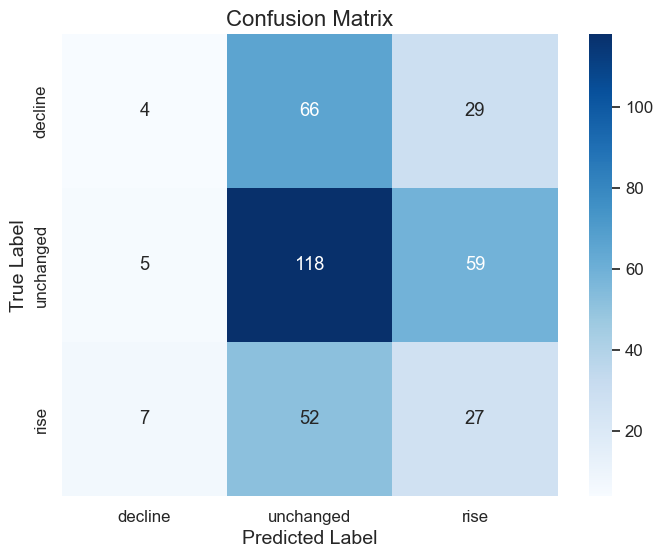

In [8]:
# The code here draws 1 label(1_trend) chart
# Draw confusion_matrix
cm = confusion_matrix(y_val[:], y_pred[:])
# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['decline', 'unchanged', 'rise'], yticklabels=['decline', 'unchanged', 'rise'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Testing

In [9]:
def create_test_features(df, days=30):
    
    features = []
    for i in range(days-1, len(df)+1, days):
        feature_row = []

        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume']
            ])

        features.append(feature_row)
    
    return np.array(features)
test_df = pd.read_csv("./data/test.csv")
test_features = create_test_features(test_df, days=30)

In [10]:
test_features.shape

(427, 150)

In [11]:
standard_feature = scaler.transform(test_features)
predictions = model.predict(standard_feature)

In [12]:
predictions

# output the prediction result to scv file
output_df = pd.DataFrame(predictions, columns=['1_trend'])
# save to csv
output_df.to_csv('output.csv', index=False)